In [2]:
import sys
import os
import json
import pandas as pd
import numpy as np
import random
import copy
from datetime import datetime
from collections import Counter, defaultdict


# Visualization packages
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Append system path
sys.path = [p for p in sys.path if not p.endswith('../..')]  # Cleans duplicated '../..'
sys.path.insert(0, '../')  # This adds `src` to the path

from helpers import io, filters, constants
from analysis import analysis_util, analysis_constants
from web_analysis import parse_robots
from web_analysis import robots_util


%load_ext autoreload
%autoreload 2

In [15]:
others = analysis_util.process_url_annotations(url_to_info)


# Stacked bar chart (y-axis: market, x-axis: num tokens, color: commercial). 
# Second chart: WildChat breakdown
# [Commercial, Market/Purpose, Num Tokens/Websites?]
# Categorize website into: []

In [16]:
others

Counter({'': 10,
         'obituary': 1,
         'perosnal blog': 1,
         'firestation': 1,
         'environmental org.': 1,
         'ex-police association': 1,
         'visually impaired people support organization': 1,
         'hoboken garden club': 1,
         'violence control support org.': 1,
         'organization for fresh water solutions': 1,
         'city club': 1,
         'survey portal': 1,
         'personal bio': 1,
         'charity organization': 1,
         'personal portfolio site': 1,
         'charity org.': 1,
         'nature , camping': 1,
         'astrology website': 1})

In [401]:
url_token_lookup = robots_util.URLTokenLookup('pretrain_data/relevant_url_token_counts.csv') # 'c4', 'rf', 'dolma'


In [3]:
url_to_info = analysis_util.extract_url_annotations(["annotated_websites/Task 1", "annotated_websites/Task 2"])

5448 rows before filtering.
3017 rows after filtering. 0 issues, 2431 unannotated.


In [403]:
url_results = analysis_util.process_url_annotations(url_to_info)

In [404]:
df = pd.DataFrame(url_results)
df = analysis_util.encode_size_columns(df, url_token_lookup)

In [405]:
df

,URL,User Content,Domains,Services,Paywall,Ads,Modality: Image,Modality: Video,Modality: Audio,Sensitive Content,c4 tokens,c4 rank,rf tokens,rf rank,dolma tokens,dolma rank,sample
0,radaronline.com,False,"[Entertainment & Culture, News]",[News/Periodicals],False,True,True,True,False,False,0,13598,12986584,1874,32410215,2287,top
1,tpmcafe.talkingpointsmemo.com,False,"[News, Legal & Policy]",[News/Periodicals],True,True,True,False,True,False,0,13768,13885085,1718,0,13774,top
2,www.medpagetoday.com,False,"[Science, Academia, & Technology, News]",[News/Periodicals],True,True,True,False,True,False,2845027,2274,26946662,685,40604734,2036,top
3,www.archive.org,False,"[General Information & Education, Books]",[Encyclopedia/Database],False,False,True,True,True,False,300186,3238,430479229,8,21716945,2739,top
4,www.authorstream.com,False,[General Information & Education],[Other],False,False,True,True,False,False,352515,3202,20447738,1021,45211642,1777,top
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,www.graphic.com.gh,False,"[News, General Information & Education]",[News/Periodicals],False,True,True,True,False,False,3784075,1996,3063702,3148,18055341,2901,top
3013,muse.jhu.edu,False,"[Science, Academia, & Technology, General Info...",[Academic],False,False,True,False,False,False,3783720,1997,32479495,541,78421759,747,top
3014,www.musicianguide.com,False,"[Entertainment & Culture, General Information ...",[Encyclopedia/Database],False,False,True,False,False,False,3783498,1998,2474094,3263,3171675,3583,top
3015,www.belfastlive.co.uk,False,"[News, General Information & Education]",[News/Periodicals],False,False,True,True,False,False,3783211,1999,8002375,2427,35109383,2191,top


In [406]:

results_df = analysis_util.analyze_url_variable_correlations(df, [100, 500, 1000], "dolma")

# Convert the dataframe to a LaTeX table
latex_table = results_df.to_latex(index=True, escape=True, float_format="{:.1f}".format)
print(latex_table)

Num URLs in Top-100: 68
Num URLs in Top-500: 323
Num URLs in Top-1000: 583
Num URLs in random sample: 1056
\begin{tabular}{lrrrrll}
\toprule
 & Top 100 & Top 500 & Top 1000 & Random & Chi-Squared Stat & P-value \\
\midrule
User Content & 22.1 & 19.5 & 18.0 & 19.1 & 2.44 & 0.12 \\
Paywall & 30.9 & 35.9 & 32.4 & 1.8 & 0.00 & 1.00 \\
Ads & 51.5 & 56.0 & 54.5 & 5.8 & 9.35 & 0.00 \\
Modality: Image & 92.7 & 98.1 & 98.5 & 94.0 & 0.03 & 0.86 \\
Modality: Video & 85.3 & 81.7 & 75.1 & 19.9 & 9.14 & 0.00 \\
Modality: Audio & 82.3 & 75.2 & 65.2 & 3.2 & 2.77 & 0.10 \\
Sensitive Content & 0.0 & 0.6 & 0.7 & 0.6 & 0.00 & 1.00 \\
domain\_Blogs & 1.5 & 1.9 & 2.1 & 16.3 & 2.51 & 0.11 \\
domain\_Books & 7.3 & 4.3 & 4.5 & 2.9 & 0.05 & 0.82 \\
domain\_Business \& E-Commerce & 13.2 & 18.0 & 18.9 & 57.6 & 0.86 & 0.35 \\
domain\_Entertainment \& Culture & 17.6 & 25.1 & 28.6 & 40.7 & 2.72 & 0.10 \\
domain\_General Information \& Education & 27.9 & 19.8 & 18.9 & 17.6 & 0.76 & 0.38 \\
domain\_Legal \& Policy & 1

In [407]:
def plot_altair_stacked_services_paywall(df, x_value='instance_count', width=800, height=400):
    """
    Plots a horizontal stacked bar chart with service categories on the y-axis
    and the specified x-value (instance rate or total tokens) on the x-axis.
    The bars are stacked based on the paywall and ads values.

    Args:
        df (pandas.DataFrame): The input dataframe with columns 'url', 'tokens',
            'services', 'paywall', and 'ads'.
        x_value (str, optional): The value to use for the x-axis. Can be 'instance_rate'
            or 'total_tokens'. Defaults to 'instance_rate'.
        width (int, optional): The width of the chart. Defaults to 800.
        height (int, optional): The height of the chart. Defaults to 400.

    Returns:
        altair.Chart: The stacked bar chart.
    """
    # Create a new column for the paywall/ads combination with custom labels
    df['paywall_ads'] = df.apply(lambda row: 'Base' if not row['Paywall'] and not row['Ads'] else
                                             'Ads' if not row['Paywall'] and row['Ads'] else
                                             'Paywall' if row['Paywall'] and not row['Ads'] else
                                             'Both Paywall & Ads', axis=1)

    # Explode the 'services' column to create a row for each service
    df = df.explode('Services')

    # Calculate the instance rate and total tokens
    instance_counts = df.groupby(['Services', 'paywall_ads']).size().reset_index(name='instance_count')
    total_tokens = df.groupby(['Services', 'paywall_ads'])['c4 tokens'].sum().reset_index(name='total_tokens')

    # Merge the instance counts and total tokens
    merged_df = instance_counts.merge(total_tokens, on=['Services', 'paywall_ads'])
    merged_df['percent'] = merged_df.groupby(['Services', 'paywall_ads'])[x_value].transform('sum') / merged_df.groupby('Services')[x_value].transform('sum') * 100
    services_ordered = merged_df.groupby('Services')[x_value].sum().sort_values(ascending=False).index.tolist()
    # print(merged_df)

    # TODO: sort dataframe
    
    # Create the chart
    chart = alt.Chart(merged_df).mark_bar().encode(
        x=alt.X(f"{x_value}:Q", title=x_value.replace('_', ' ').title()),
        y=alt.Y(
            'Services:N', 
            # sort='-x', 
            sort=services_ordered,
            title='Service Categories'
        ),
        color=alt.Color('paywall_ads:N', title=None,
                        sort=['Base', 'Paywall', 'Ads', 'Both Paywall & Ads'],
                        scale=alt.Scale(
                            domain=['Base', 'Ads', 'Paywall', 'Both Paywall & Ads'],
                            range=['#8dd3c7', '#fb8072', '#ffffb3', '#bebada']
                        ),
                        legend=alt.Legend(
                            orient='top',
                            title=None,
                            labelFontSize=12,
                            labelPadding=5,
                            labelColor='black',
                            labelFontWeight='bold'
                        )
                        ),
        order="order:Q",
        tooltip=['Services', 'paywall_ads', f"{x_value}:Q"]
    ).properties(
        width=width,
        height=height
    )


    return chart

In [408]:
chart = plot_altair_stacked_services_paywall(df, x_value='total_tokens')
chart.show()

alt.Chart(...)

In [465]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# from itertools import cycle

# def plot_modality_stacked_bar(df, normalize_by='token_count', modality_row=False):
#     """
#     Plots a horizontal, normalized stacked bar chart for modalities across domains.
    
#     Args:
#         df (pandas.DataFrame): The input dataframe with columns 'tokens', 'domains', and 'modality: *' columns.
#         normalize_by (str, optional): The normalization factor, either 'token_count' or 'url_count'. Defaults to 'token_count'.
        
#     Returns:
#         matplotlib.axes._subplots.AxesSubplot: The matplotlib axes object containing the plot.
#     """
    
#     # Validate the normalization factor
#     if normalize_by not in ['token_count', 'url_count']:
#         raise ValueError("normalize_by must be either 'token_count' or 'url_count'")
    
#     # Explode the 'domains' column
#     df = df.explode('Domains')
#     df = df[~df["Domains"].isna()]
#     # print(df)
    
#     # Get the modality columns
#     modality_cols = [col for col in df.columns if col.startswith('Modality')]
#     # print(modality_cols)
    
#     # Normalize the data based on the chosen factor
#     if normalize_by == 'token_count':
#         normalize_factor = df['c4 tokens'].sum()
#     else:
#         normalize_factor = len(df)
    
#     # Create the plot
#     fig, ax = plt.subplots(figsize=(10, 6))
#     colors = cycle('bgrcmyk')


#     for col in modality_cols:
#         # Group the data by domain and modality, and calculate the sum of tokens
#         grouped = df.groupby(['Domains', col])['c4 tokens'].sum().reset_index()
        
#         # Calculate the total tokens for the current modality
#         total_tokens = grouped[grouped[col]][['c4 tokens']].sum().values[0]
        
#         # Calculate the portion of tokens for each domain
#         grouped['portion'] = grouped['c4 tokens'] / total_tokens
        
#         # Plot the bars
#         for domain, portion in grouped[grouped[col]][['Domains', 'portion']].values:
#             color = next(colors)
#             ax.barh(col.split(': ')[-1], portion, label=domain, color=color)

#     ax.set_yticks(np.arange(len(modality_cols)))
#     ax.set_yticklabels([col.split(': ')[-1] for col in modality_cols])
#     ax.set_title(f'Domain Distribution across Modalities (Normalized by {normalize_by})')

#     ax.set_xlabel('Modality' if normalize_by == 'token_count' else 'URL Count')

#     ax.legend(loc='upper right')
    
#     return ax

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from matplotlib.font_manager import FontProperties

def plot_modality_stacked_bar(df, normalize_by='token_count', modality_row=False, font_family='Arial', font_size=12, remove_box=False):
    """
    Plots a horizontal, normalized stacked bar chart for modalities across domains.

    Args:
        df (pandas.DataFrame): The input dataframe with columns 'c4 tokens', 'Domains', and 'Modality: *' columns.
        normalize_by (str, optional): The normalization factor, either 'token_count' or 'url_count'. Defaults to 'token_count'.
        modality_row (bool, optional): If True, plot modalities as rows instead of columns. Defaults to False.
        font_family (str, optional): Font family for labels and title. Defaults to 'Arial'.
        font_size (int, optional): Font size for labels and title. Defaults to 12.
        remove_box (bool, optional): If True, remove the outer box around the plot. Defaults to False.

    Returns:
        matplotlib.axes._subplots.AxesSubplot: The matplotlib axes object containing the plot.
    """
    
    # Validate the normalization factor
    if normalize_by not in ['token_count', 'url_count']:
        raise ValueError("normalize_by must be either 'token_count' or 'url_count'")

    # Explode the 'Domains' column
    df = df.explode('Domains')
    df = df[~df["Domains"].isna()]

    # Get the modality columns
    modality_cols = [col for col in df.columns if col.startswith('Modality')]

    # Normalize the data based on the chosen factor
    if normalize_by == 'token_count':
        normalize_factor = df['c4 tokens'].sum()
    else:
        normalize_factor = len(df)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = cycle('bgrcmyk')

    # Set font properties
    font_prop = FontProperties(family=font_family, size=font_size)

    # Plot the bars
    handles = []
    for col in modality_cols:
        # Group the data by domain and modality, and calculate the sum of tokens
        grouped = df.groupby(['Domains', col])['c4 tokens'].sum().reset_index()

        # Calculate the total tokens for the current modality
        total_tokens = grouped[grouped[col]]['c4 tokens'].sum()

        # Calculate the portion of tokens for each domain
        grouped['portion'] = grouped['c4 tokens'] / total_tokens

        for domain, portion in grouped[grouped[col]][['Domains', 'portion']].values:
            color = next(colors)
            label = domain if modality_row else col.split(': ')[-1]
            handle = ax.barh(col.split(': ')[-1], portion, label=label, color=color) if not modality_row else ax.barh(domain, portion, label=label, color=color)
            handles.append(handle)

    # Set labels, title, and legend
    ax.set_xlabel('Modality' if normalize_by == 'token_count' else 'URL Count', fontproperties=font_prop)
    ax.set_title(f'Domain Distribution across Modalities (Normalized by {normalize_by})', fontproperties=font_prop)
    if modality_row:
        ax.set_yticks(range(len(df['Domains'].unique())))
        ax.set_yticklabels(df['Domains'].unique(), fontproperties=font_prop)
    else:
        ax.set_yticks(range(len(modality_cols)))
        ax.set_yticklabels([col.split(': ')[-1] for col in modality_cols], fontproperties=font_prop)
    ax.legend(handles=handles, loc='upper right', prop=font_prop)

    # Remove the outer box
    if remove_box:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    return ax

In [466]:
df_uc = df[df["sample"] != "random"]

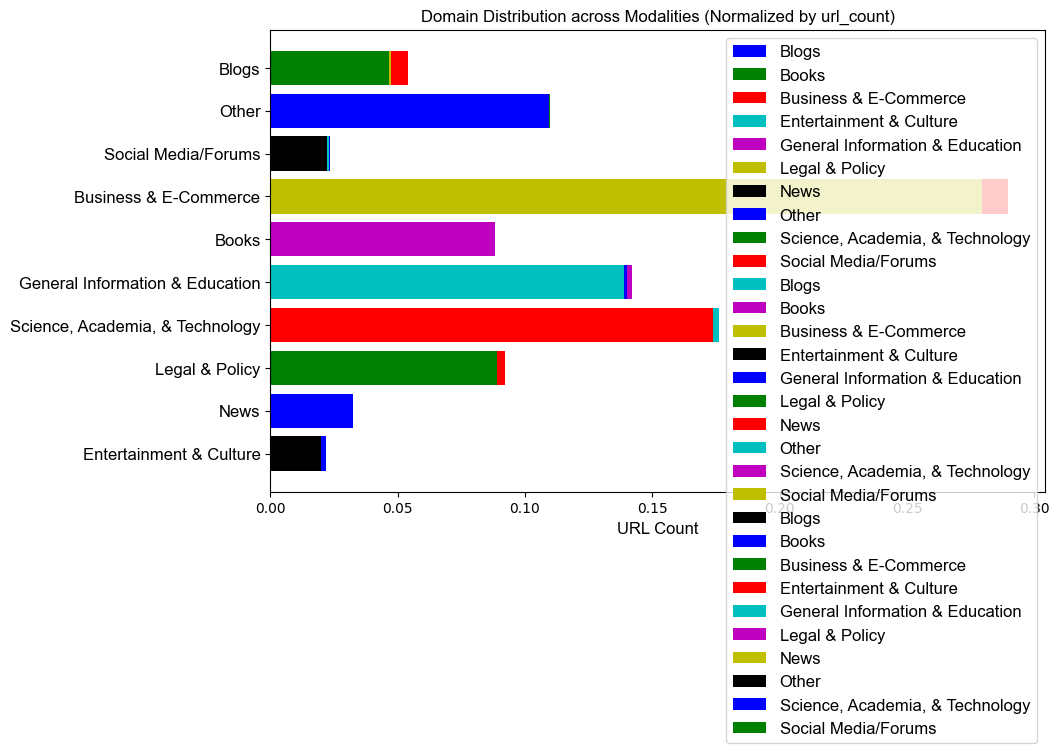

In [467]:
# Normalize by token count
# ax = plot_modality_stacked_bar(df, normalize_by='token_count')

# Normalize by URL count
ax = plot_modality_stacked_bar(df_uc, normalize_by='url_count', modality_row=True)

In [452]:
import pandas as pd

# Explode the 'domains' column
dfx = df.explode('Domains')

# Get the unique domain categories
domain_categories = dfx['Domains'].unique()

# Create a new column for each domain category with True/False values
for category in domain_categories:
    df[f'domain_{category}'] = df['Domains'].apply(lambda x: category in x)

# Filter the DataFrame to only include rows with video modality
df_with_videos = df[df['Modality: Video']]

# Calculate the portion of URLs with videos for each domain category
portions_by_category = {}
for category in domain_categories:
    category_col = f'domain_{category}'
    total_videos = len(df_with_videos)
    videos_in_category = df_with_videos[category_col].sum()
    portion = videos_in_category / total_videos
    portions_by_category[category] = portion

# Print the results
tot_portions = sum(portions_by_category.values())
for category, portion in portions_by_category.items():
    print(f"{category}: {100 * portion / tot_portions :.2f}%")
# print(sum(tot_portions))

Entertainment & Culture: 20.21%
News: 29.28%
Legal & Policy: 4.30%
Science, Academia, & Technology: 11.14%
General Information & Education: 11.22%
Books: 1.94%
Business & E-Commerce: 11.65%
Social Media/Forums: 4.18%
Other: 3.08%
Blogs: 3.00%
nan: 0.00%


In [ ]:
# filter for available rows and print out how many are available [X]
# process each row to create domains, services, and others. [X]
# load new dataframes for random sample Task 1. [X]
# add code to review "other" categorizations for both domain and typ. [X]
# plot head vs tail chi squared and other stats for every variable [X]
# move all code to utils for clean-up [X]
# plot bar chart: paywall/ads by domain/service to illustrate market
# User-content plot: (broken down by modality + user content)

In [ ]:
# fix seaborn user content percentages
# fix seaborn plot and add things

In [264]:
# Service, paywall/ads plot: seaborn, right order, percentages for URLs and tokens, font.
# User-content plot: seaborn, right order, percentages for URLs and tokens, font.
# Try both random and head for both

In [411]:
rdf = df.explode("Domains")

In [453]:
# rdf[rdf["Domains"].isna()]